# Phase 4: Feature Engineering
## Electrical Fault Detection and Classification Project

**Objective:** Engineer new features to improve model performance from baseline ~88% to target >95% accuracy.

**Approach:**
1. Create polynomial features (interaction terms)
2. Create domain-based electrical features (physics-informed)
3. Train models with new features
4. Compare performance improvements

## 1. Setup and Imports

In [15]:
# Data manipulation
import pandas as pd
import numpy as np
import os

# Preprocessing and modeling
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. Create Directory Structure

In [16]:
# Create directories if they don't exist
os.makedirs('../results/feature_engineering', exist_ok=True)
os.makedirs('../results/feature_engineering/plots', exist_ok=True)
os.makedirs('../results/feature_engineering/metrics', exist_ok=True)

# Define output directories
output_dir = '../results/feature_engineering'
plots_dir = os.path.join(output_dir, 'plots')
metrics_dir = os.path.join(output_dir, 'metrics')

print('Directory structure created successfully!')
print(f'Output directory: {output_dir}')
print(f'Plots directory: {plots_dir}')
print(f'Metrics directory: {metrics_dir}')

Directory structure created successfully!
Output directory: ../results/feature_engineering
Plots directory: ../results/feature_engineering/plots
Metrics directory: ../results/feature_engineering/metrics


## 3. Load Preprocessed Data

In [17]:
print('LOADING PREPROCESSED DATA')
print('-'*60)

# Load train/test data
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load feature names
with open('../data/processed/feature_names.txt', 'r') as f:
    original_features = [line.strip() for line in f.readlines()]

# Load label encoder (with fallback)
try:
    with open('../models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    print('Label encoder loaded from pickle')
    
except Exception as e:
    print(f'Could not load pickle: {e}')
    print('Recreating label encoder...')
    
    # Recreate from raw data
    df = pd.read_csv('../data/raw/classData.csv')
    
    def get_fault_type(row):
        fault = ''
        if row['A'] == 1: fault += 'A'
        if row['B'] == 1: fault += 'B'
        if row['C'] == 1: fault += 'C'
        if row['G'] == 1: fault += 'G'
        return fault if fault else 'Normal'
    
    df['fault_type'] = df.apply(get_fault_type, axis=1)
    label_encoder = LabelEncoder()
    label_encoder.fit(df['fault_type'])
    
    # Save the new one
    with open('../models/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print('Label encoder recreated and saved')

print(f'\nTraining set: {X_train.shape[0]} samples, {X_train.shape[1]} features')
print(f'Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features')
print(f'Original features: {original_features}')
print(f'Number of classes: {len(label_encoder.classes_)}')
print(f'Class names: {list(label_encoder.classes_)}')

LOADING PREPROCESSED DATA
------------------------------------------------------------
Label encoder loaded from pickle

Training set: 6288 samples, 6 features
Test set: 1573 samples, 6 features
Original features: ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
Number of classes: 6
Class names: ['ABC', 'ABCG', 'ABG', 'AG', 'BC', 'Normal']


## 4. Load Baseline Results

In [18]:
# Load baseline results for comparison
baseline_results = pd.read_csv('../results/preprocessing/metrics/baseline_model_results.csv')

print('BASELINE MODEL PERFORMANCE (Phase 3)')
print('-'*60)
print(baseline_results.to_string(index=False))
print('\nTarget: Improve to >95% accuracy')

BASELINE MODEL PERFORMANCE (Phase 3)
------------------------------------------------------------
              Model  CV Accuracy (Mean)  CV Std Dev  Test Accuracy
Logistic Regression              0.3381      0.0103         0.3458
      Decision Tree              0.8631      0.0072         0.8856
      Random Forest              0.8599      0.0054         0.8798

Target: Improve to >95% accuracy


## 5. Feature Engineering Strategy

**Phase A: Polynomial Features**
- Create interaction terms between existing features
- Example: Ia × Ib, Va × Vb, Ia × Va, etc.
- Helps capture non-linear relationships

**Phase B: Domain-Based Features**
- Zero-sequence components (critical for ground faults)
- Voltage/Current ratios (impedance indicators)
- Total magnitudes and imbalances
- Power approximations
- Phase differences

In [19]:
print('FEATURE ENGINEERING STRATEGY')
print('-'*60)
print(f'\nCurrent features ({len(original_features)}): {original_features}')
print('\nPhase A: Polynomial Features')
print('  - Interaction terms (degree 2)')
print('  - Expected: ~27 features')
print('\nPhase B: Domain-Based Features')
print('  - Zero-sequence: I0, V0')
print('  - Impedances: Z_a, Z_b, Z_c')
print('  - Magnitudes: I_total, V_total')
print('  - Imbalances: I_imbalance, V_imbalance')
print('  - Power: P_a, P_b, P_c, P_total')
print('  - Sums and differences')
print('  - Expected: ~28 additional features')

FEATURE ENGINEERING STRATEGY
------------------------------------------------------------

Current features (6): ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

Phase A: Polynomial Features
  - Interaction terms (degree 2)
  - Expected: ~27 features

Phase B: Domain-Based Features
  - Zero-sequence: I0, V0
  - Impedances: Z_a, Z_b, Z_c
  - Magnitudes: I_total, V_total
  - Imbalances: I_imbalance, V_imbalance
  - Power: P_a, P_b, P_c, P_total
  - Sums and differences
  - Expected: ~28 additional features


## 6. Phase A: Create Polynomial Features

In [36]:
print('PHASE A: CREATING POLYNOMIAL FEATURES')
print('-'*60)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit on training data and transform both sets
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Get feature names
poly_feature_names = poly.get_feature_names_out(original_features)

print(f'\nOriginal features: {X_train.shape[1]}')
print(f'After polynomial expansion: {X_train_poly.shape[1]}')
print(f'New features created: {X_train_poly.shape[1] - X_train.shape[1]}')
print(f'\nSample of new feature names:')
for i, name in enumerate(poly_feature_names):
    print(f'  {i+1:2d}. {name}')

PHASE A: CREATING POLYNOMIAL FEATURES
------------------------------------------------------------

Original features: 6
After polynomial expansion: 27
New features created: 21

Sample of new feature names:
   1. Ia
   2. Ib
   3. Ic
   4. Va
   5. Vb
   6. Vc
   7. Ia^2
   8. Ia Ib
   9. Ia Ic
  10. Ia Va
  11. Ia Vb
  12. Ia Vc
  13. Ib^2
  14. Ib Ic
  15. Ib Va
  16. Ib Vb
  17. Ib Vc
  18. Ic^2
  19. Ic Va
  20. Ic Vb
  21. Ic Vc
  22. Va^2
  23. Va Vb
  24. Va Vc
  25. Vb^2
  26. Vb Vc
  27. Vc^2


## 7. Phase B: Create Domain-Based Features

These features are based on electrical engineering principles:
- **Zero-sequence components**: Indicate ground faults
- **Impedance (V/I ratios)**: Changes during faults
- **Imbalances**: Asymmetry indicators
- **Power approximations**: Overall system behavior

In [21]:
def add_domain_features(X, feature_names):
    """
    Add domain-specific electrical features to the dataset.
    
    Parameters:
    -----------
    X : numpy array
        Feature matrix with columns: [Ia, Ib, Ic, Va, Vb, Vc]
    feature_names : list
        List of current feature names
    
    Returns:
    --------
    X_enhanced : numpy array
        Enhanced feature matrix
    new_feature_names : list
        Updated list of feature names
    """
    
    # Extract individual features (assuming order: Ia, Ib, Ic, Va, Vb, Vc)
    Ia = X[:, 0]
    Ib = X[:, 1]
    Ic = X[:, 2]
    Va = X[:, 3]
    Vb = X[:, 4]
    Vc = X[:, 5]
    
    new_features = []
    new_names = []
    
    # 1. Zero-sequence components (critical for ground fault detection)
    I0 = (Ia + Ib + Ic) / 3
    V0 = (Va + Vb + Vc) / 3
    new_features.extend([I0, V0])
    new_names.extend(['I0_zero_seq', 'V0_zero_seq'])
    
    # 2. Positive-sequence approximations
    I1 = np.sqrt(Ia**2 + Ib**2 + Ic**2) / np.sqrt(3)
    V1 = np.sqrt(Va**2 + Vb**2 + Vc**2) / np.sqrt(3)
    new_features.extend([I1, V1])
    new_names.extend(['I1_pos_seq', 'V1_pos_seq'])
    
    # 3. Voltage/Current ratios (impedance indicators)
    epsilon = 1e-6
    Z_a = Va / (Ia + epsilon)
    Z_b = Vb / (Ib + epsilon)
    Z_c = Vc / (Ic + epsilon)
    new_features.extend([Z_a, Z_b, Z_c])
    new_names.extend(['Z_phase_a', 'Z_phase_b', 'Z_phase_c'])
    
    # 4. Total current and voltage magnitudes
    I_total = np.sqrt(Ia**2 + Ib**2 + Ic**2)
    V_total = np.sqrt(Va**2 + Vb**2 + Vc**2)
    new_features.extend([I_total, V_total])
    new_names.extend(['I_total_magnitude', 'V_total_magnitude'])
    
    # 5. Current imbalance indicator
    I_max = np.maximum(np.abs(Ia), np.maximum(np.abs(Ib), np.abs(Ic)))
    I_min = np.minimum(np.abs(Ia), np.minimum(np.abs(Ib), np.abs(Ic)))
    I_imbalance = I_max - I_min
    new_features.append(I_imbalance)
    new_names.append('I_imbalance')
    
    # 6. Voltage imbalance indicator
    V_max = np.maximum(np.abs(Va), np.maximum(np.abs(Vb), np.abs(Vc)))
    V_min = np.minimum(np.abs(Va), np.minimum(np.abs(Vb), np.abs(Vc)))
    V_imbalance = V_max - V_min
    new_features.append(V_imbalance)
    new_names.append('V_imbalance')
    
    # 7. Power approximations (V × I for each phase)
    P_a = Va * Ia
    P_b = Vb * Ib
    P_c = Vc * Ic
    P_total = P_a + P_b + P_c
    new_features.extend([P_a, P_b, P_c, P_total])
    new_names.extend(['P_phase_a', 'P_phase_b', 'P_phase_c', 'P_total'])
    
    # 8. Current sum (should be ~0 for balanced, non-zero for ground faults)
    I_sum = Ia + Ib + Ic
    new_features.append(I_sum)
    new_names.append('I_sum')
    
    # 9. Voltage sum (should be ~0 for balanced system)
    V_sum = Va + Vb + Vc
    new_features.append(V_sum)
    new_names.append('V_sum')
    
    # 10. Phase differences (approximated using squared differences)
    I_diff_ab = (Ia - Ib) ** 2
    I_diff_bc = (Ib - Ic) ** 2
    I_diff_ca = (Ic - Ia) ** 2
    new_features.extend([I_diff_ab, I_diff_bc, I_diff_ca])
    new_names.extend(['I_diff_ab', 'I_diff_bc', 'I_diff_ca'])
    
    V_diff_ab = (Va - Vb) ** 2
    V_diff_bc = (Vb - Vc) ** 2
    V_diff_ca = (Vc - Va) ** 2
    new_features.extend([V_diff_ab, V_diff_bc, V_diff_ca])
    new_names.extend(['V_diff_ab', 'V_diff_bc', 'V_diff_ca'])
    
    # Convert to numpy array
    new_features_array = np.column_stack(new_features)
    
    # Combine with original features
    X_enhanced = np.hstack([X, new_features_array])
    
    # Combine feature names
    all_feature_names = feature_names + new_names
    
    return X_enhanced, all_feature_names

print('Domain feature engineering function defined')

Domain feature engineering function defined


In [22]:
print('PHASE B: CREATING DOMAIN-BASED FEATURES')
print('-'*60)

# Create domain features
X_train_domain, domain_feature_names = add_domain_features(X_train, original_features)
X_test_domain, _ = add_domain_features(X_test, original_features)

print(f'\nOriginal features: {X_train.shape[1]}')
print(f'After domain features: {X_train_domain.shape[1]}')
print(f'New domain features created: {X_train_domain.shape[1] - X_train.shape[1]}')

print(f'\nDomain feature names added:')
new_domain_features = domain_feature_names[len(original_features):]
for i, name in enumerate(new_domain_features, 1):
    print(f'  {i:2d}. {name}')

PHASE B: CREATING DOMAIN-BASED FEATURES
------------------------------------------------------------

Original features: 6
After domain features: 29
New domain features created: 23

Domain feature names added:
   1. I0_zero_seq
   2. V0_zero_seq
   3. I1_pos_seq
   4. V1_pos_seq
   5. Z_phase_a
   6. Z_phase_b
   7. Z_phase_c
   8. I_total_magnitude
   9. V_total_magnitude
  10. I_imbalance
  11. V_imbalance
  12. P_phase_a
  13. P_phase_b
  14. P_phase_c
  15. P_total
  16. I_sum
  17. V_sum
  18. I_diff_ab
  19. I_diff_bc
  20. I_diff_ca
  21. V_diff_ab
  22. V_diff_bc
  23. V_diff_ca


## 8. Visualize Domain Features

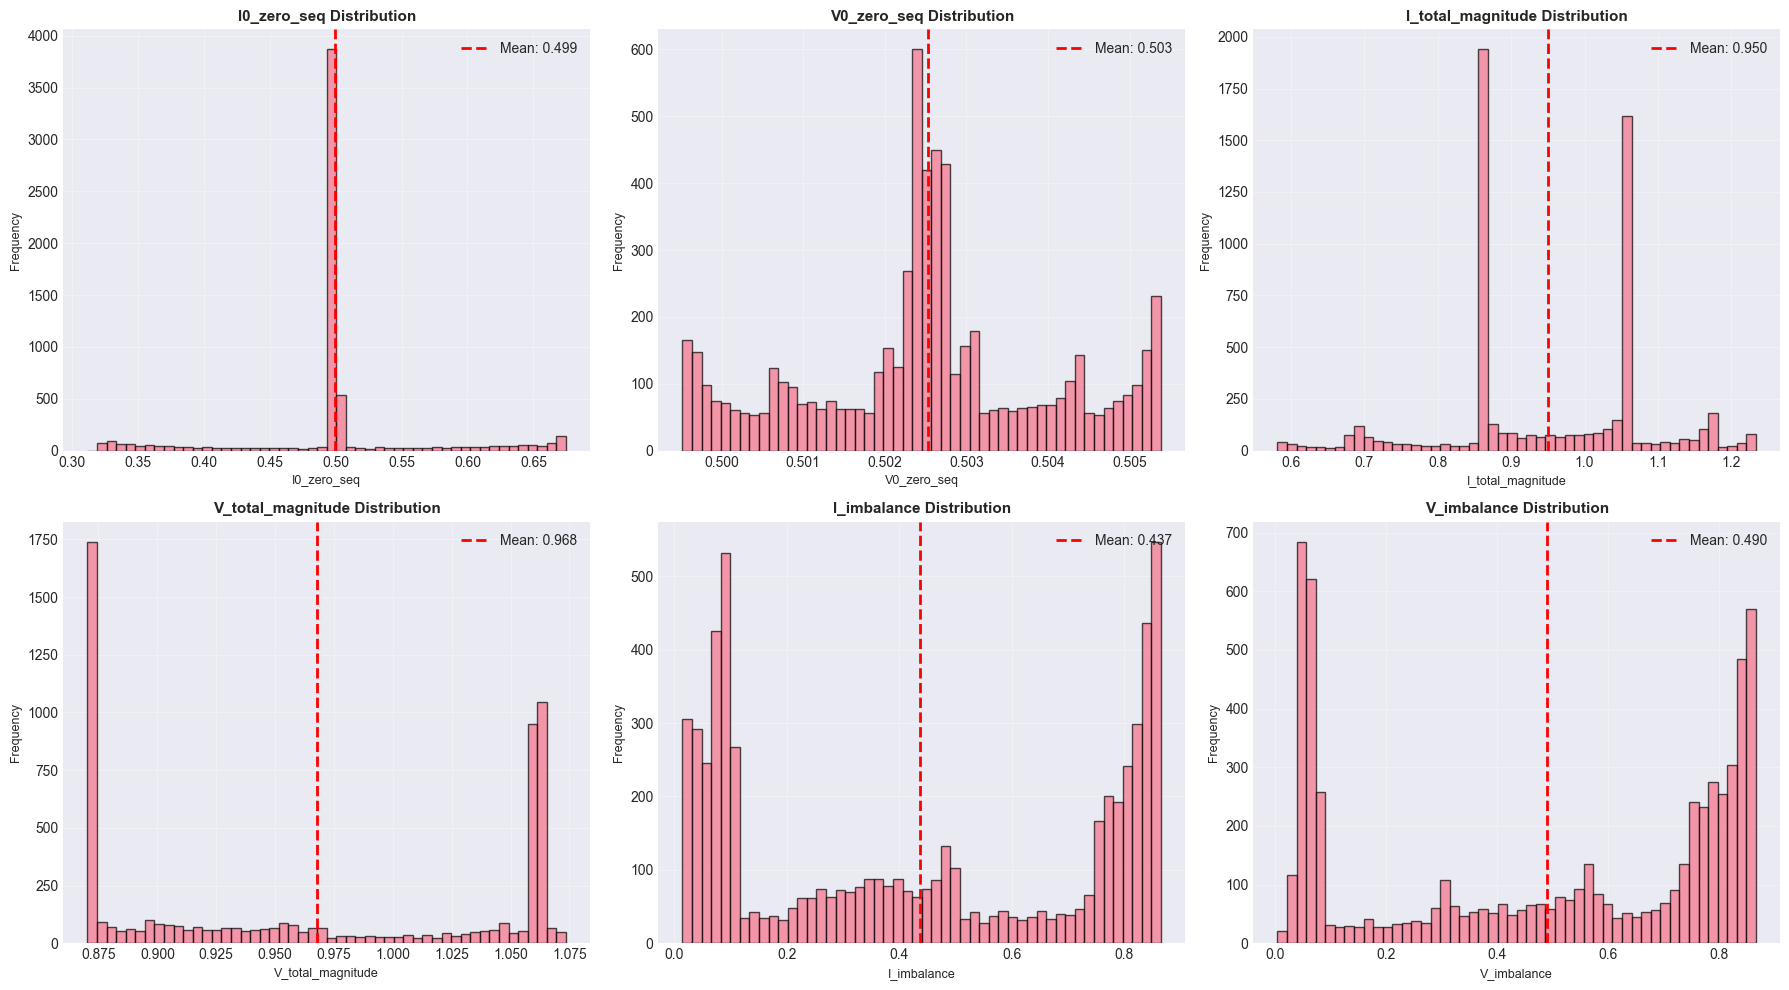

Domain feature distributions visualized and saved!


In [23]:
# Create DataFrame for easier visualization
train_domain_df = pd.DataFrame(X_train_domain, columns=domain_feature_names)

# Select key domain features to visualize
key_domain_features = ['I0_zero_seq', 'V0_zero_seq', 'I_total_magnitude', 
                       'V_total_magnitude', 'I_imbalance', 'V_imbalance']

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_domain_features):
    axes[idx].hist(train_domain_df[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)
    axes[idx].axvline(train_domain_df[feature].mean(), color='red', 
                     linestyle='--', linewidth=2, 
                     label=f'Mean: {train_domain_df[feature].mean():.3f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'domain_features_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print('Domain feature distributions visualized and saved!')

## 9. Setup Cross-Validation

In [24]:
# Setup stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('TRAINING MODELS WITH ENGINEERED FEATURES')
print('-'*60)
print('Cross-validation: 5-fold Stratified K-Fold')

TRAINING MODELS WITH ENGINEERED FEATURES
------------------------------------------------------------
Cross-validation: 5-fold Stratified K-Fold


## 10. Train Models with Domain Features

In [25]:
print('\nSCENARIO 1: DOMAIN FEATURES ONLY')
print('-'*60)
print(f'Feature count: {X_train_domain.shape[1]}')

# Dictionary to store results
domain_results = {}

# 1. Logistic Regression with Domain Features
print('\n1. Training Logistic Regression...')
lr_domain = LogisticRegression(max_iter=1000, random_state=42)
cv_scores = cross_val_score(lr_domain, X_train_domain, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
lr_domain.fit(X_train_domain, y_train)
y_pred_lr = lr_domain.predict(X_test_domain)
test_acc_lr = accuracy_score(y_test, y_pred_lr)

domain_results['Logistic Regression'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_lr
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_lr:.4f}')

# 2. Decision Tree with Domain Features
print('\n2. Training Decision Tree...')
dt_domain = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt_domain, X_train_domain, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
dt_domain.fit(X_train_domain, y_train)
y_pred_dt = dt_domain.predict(X_test_domain)
test_acc_dt = accuracy_score(y_test, y_pred_dt)

domain_results['Decision Tree'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_dt
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_dt:.4f}')

# 3. Random Forest with Domain Features
print('\n3. Training Random Forest...')
rf_domain = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf_domain, X_train_domain, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
rf_domain.fit(X_train_domain, y_train)
y_pred_rf = rf_domain.predict(X_test_domain)
test_acc_rf = accuracy_score(y_test, y_pred_rf)

domain_results['Random Forest'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_rf
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_rf:.4f}')

print('\nTraining with domain features complete!')


SCENARIO 1: DOMAIN FEATURES ONLY
------------------------------------------------------------
Feature count: 29

1. Training Logistic Regression...
   CV Accuracy: 0.7231 (+/- 0.0132)
   Test Accuracy: 0.7298

2. Training Decision Tree...
   CV Accuracy: 0.9774 (+/- 0.0034)
   Test Accuracy: 0.9822

3. Training Random Forest...
   CV Accuracy: 0.9909 (+/- 0.0028)
   Test Accuracy: 0.9943

Training with domain features complete!


## 11. Train Models with Polynomial Features

In [26]:
print('\nSCENARIO 2: POLYNOMIAL FEATURES')
print('-'*60)
print(f'Feature count: {X_train_poly.shape[1]}')

# Dictionary to store results
poly_results = {}

# 1. Logistic Regression with Polynomial Features
print('\n1. Training Logistic Regression...')
lr_poly = LogisticRegression(max_iter=1000, random_state=42)
cv_scores = cross_val_score(lr_poly, X_train_poly, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
lr_poly.fit(X_train_poly, y_train)
y_pred_lr_poly = lr_poly.predict(X_test_poly)
test_acc_lr_poly = accuracy_score(y_test, y_pred_lr_poly)

poly_results['Logistic Regression'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_lr_poly
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_lr_poly:.4f}')

# 2. Decision Tree with Polynomial Features
print('\n2. Training Decision Tree...')
dt_poly = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt_poly, X_train_poly, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
dt_poly.fit(X_train_poly, y_train)
y_pred_dt_poly = dt_poly.predict(X_test_poly)
test_acc_dt_poly = accuracy_score(y_test, y_pred_dt_poly)

poly_results['Decision Tree'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_dt_poly
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_dt_poly:.4f}')

# 3. Random Forest with Polynomial Features
print('\n3. Training Random Forest...')
rf_poly = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf_poly, X_train_poly, y_train, cv=cv, 
                            scoring='accuracy', n_jobs=-1)
rf_poly.fit(X_train_poly, y_train)
y_pred_rf_poly = rf_poly.predict(X_test_poly)
test_acc_rf_poly = accuracy_score(y_test, y_pred_rf_poly)

poly_results['Random Forest'] = {
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_acc': test_acc_rf_poly
}

print(f'   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
print(f'   Test Accuracy: {test_acc_rf_poly:.4f}')

print('\nTraining with polynomial features complete!')


SCENARIO 2: POLYNOMIAL FEATURES
------------------------------------------------------------
Feature count: 27

1. Training Logistic Regression...
   CV Accuracy: 0.7355 (+/- 0.0149)
   Test Accuracy: 0.7438

2. Training Decision Tree...
   CV Accuracy: 0.8761 (+/- 0.0083)
   Test Accuracy: 0.9027

3. Training Random Forest...
   CV Accuracy: 0.8678 (+/- 0.0047)
   Test Accuracy: 0.8900

Training with polynomial features complete!


## 12. Performance Comparison

In [27]:
print('\nCOMPREHENSIVE PERFORMANCE COMPARISON')
print('-'*60)

# Create comparison DataFrame
comparison_data = []

# Baseline results (from Phase 3)
baseline_data = {
    'Logistic Regression': {'test_acc': 0.3458},
    'Decision Tree': {'test_acc': 0.8856},
    'Random Forest': {'test_acc': 0.8798}
}

for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    comparison_data.append({
        'Model': model_name,
        'Feature Set': 'Baseline (6 features)',
        'Test Accuracy': baseline_data[model_name]['test_acc'],
        'Improvement': 0.0
    })
    
    # Domain features
    test_acc_domain = domain_results[model_name]['test_acc']
    improvement_domain = test_acc_domain - baseline_data[model_name]['test_acc']
    comparison_data.append({
        'Model': model_name,
        'Feature Set': f'Domain ({X_train_domain.shape[1]} features)',
        'Test Accuracy': test_acc_domain,
        'Improvement': improvement_domain
    })
    
    # Polynomial features
    test_acc_poly = poly_results[model_name]['test_acc']
    improvement_poly = test_acc_poly - baseline_data[model_name]['test_acc']
    comparison_data.append({
        'Model': model_name,
        'Feature Set': f'Polynomial ({X_train_poly.shape[1]} features)',
        'Test Accuracy': test_acc_poly,
        'Improvement': improvement_poly
    })

comparison_df = pd.DataFrame(comparison_data)

print('\n' + comparison_df.to_string(index=False))

# Save comparison results
comparison_df.to_csv(os.path.join(metrics_dir, 'feature_engineering_comparison.csv'), 
                     index=False)
print('\nComparison saved to metrics directory')


COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------

              Model              Feature Set  Test Accuracy  Improvement
Logistic Regression    Baseline (6 features)       0.345800     0.000000
Logistic Regression     Domain (29 features)       0.729816     0.384016
Logistic Regression Polynomial (27 features)       0.743802     0.398002
      Decision Tree    Baseline (6 features)       0.885600     0.000000
      Decision Tree     Domain (29 features)       0.982200     0.096600
      Decision Tree Polynomial (27 features)       0.902734     0.017134
      Random Forest    Baseline (6 features)       0.879800     0.000000
      Random Forest     Domain (29 features)       0.994278     0.114478
      Random Forest Polynomial (27 features)       0.890019     0.010219

Comparison saved to metrics directory


## 13. Visualize Performance Comparison

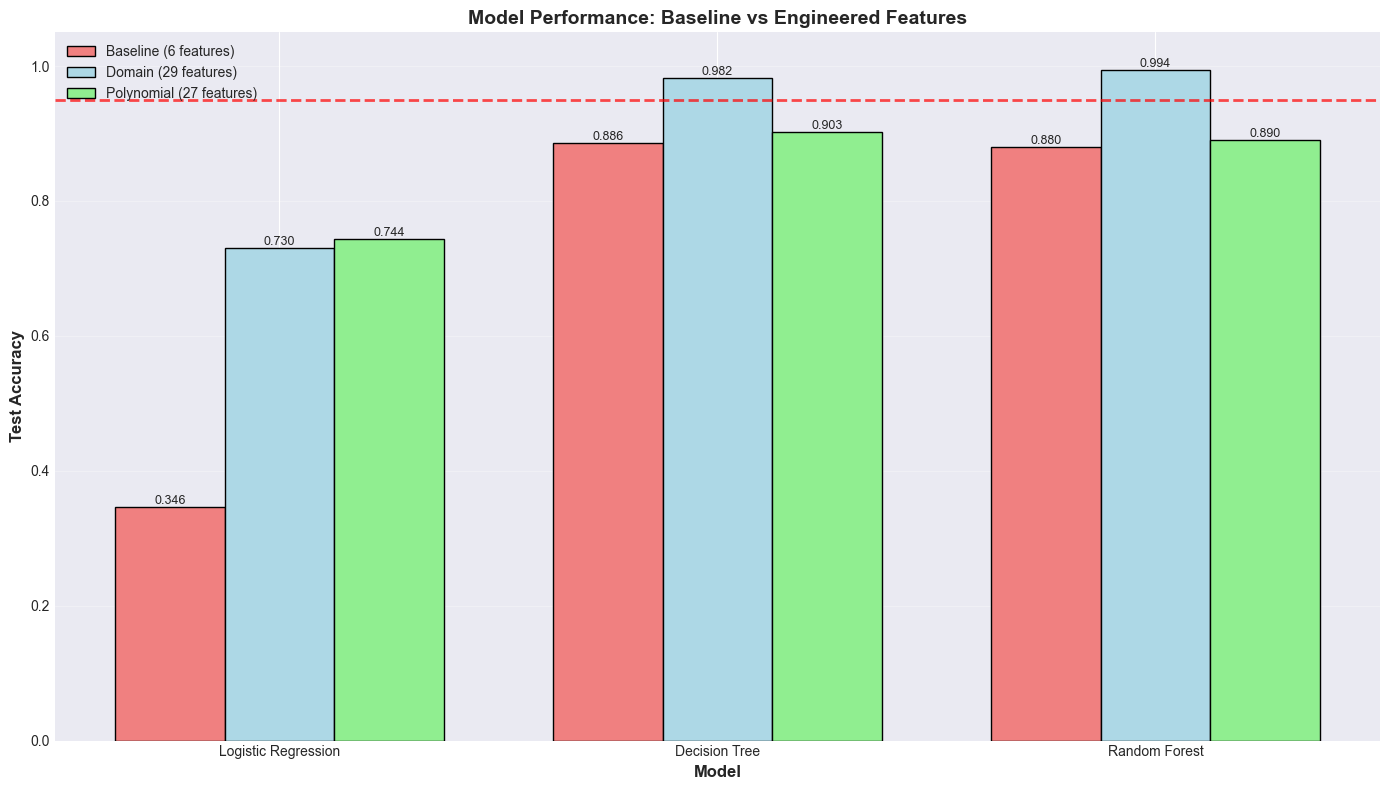

Performance comparison visualized and saved!


In [28]:
# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))

models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
x = np.arange(len(models))
width = 0.25

baseline_scores = [baseline_data[m]['test_acc'] for m in models]
domain_scores = [domain_results[m]['test_acc'] for m in models]
poly_scores = [poly_results[m]['test_acc'] for m in models]

bars1 = ax.bar(x - width, baseline_scores, width, label='Baseline (6 features)', 
               color='lightcoral', edgecolor='black')
bars2 = ax.bar(x, domain_scores, width, 
               label=f'Domain ({X_train_domain.shape[1]} features)', 
               color='lightblue', edgecolor='black')
bars3 = ax.bar(x + width, poly_scores, width, 
               label=f'Polynomial ({X_train_poly.shape[1]} features)', 
               color='lightgreen', edgecolor='black')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Baseline vs Engineered Features', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Add target line
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, 
           label='Target (95%)', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'performance_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print('Performance comparison visualized and saved!')

## 14. Identify Best Model

In [29]:
print('\nIDENTIFYING BEST MODEL')
print('-'*60)

# Find best model across all scenarios
best_accuracy = 0
best_model = None
best_config = None

for model_name in models:
    # Check domain features
    if domain_results[model_name]['test_acc'] > best_accuracy:
        best_accuracy = domain_results[model_name]['test_acc']
        best_model = model_name
        best_config = 'Domain Features'
    
    # Check polynomial features
    if poly_results[model_name]['test_acc'] > best_accuracy:
        best_accuracy = poly_results[model_name]['test_acc']
        best_model = model_name
        best_config = 'Polynomial Features'

print(f'\nBest Model: {best_model}')
print(f'Feature Set: {best_config}')
print(f'Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)')

# Get the best model object and predictions
if best_model == 'Logistic Regression':
    if best_config == 'Domain Features':
        best_model_obj = lr_domain
        best_X_test = X_test_domain
        best_y_pred = y_pred_lr
    else:
        best_model_obj = lr_poly
        best_X_test = X_test_poly
        best_y_pred = y_pred_lr_poly
elif best_model == 'Decision Tree':
    if best_config == 'Domain Features':
        best_model_obj = dt_domain
        best_X_test = X_test_domain
        best_y_pred = y_pred_dt
    else:
        best_model_obj = dt_poly
        best_X_test = X_test_poly
        best_y_pred = y_pred_dt_poly
else:  # Random Forest
    if best_config == 'Domain Features':
        best_model_obj = rf_domain
        best_X_test = X_test_domain
        best_y_pred = y_pred_rf
    else:
        best_model_obj = rf_poly
        best_X_test = X_test_poly
        best_y_pred = y_pred_rf_poly


IDENTIFYING BEST MODEL
------------------------------------------------------------

Best Model: Random Forest
Feature Set: Domain Features
Test Accuracy: 0.9943 (99.43%)


## 15. Classification Report for Best Model

In [30]:
print('\nCLASSIFICATION REPORT - BEST MODEL')
print('-'*60)

# Generate classification report
class_report = classification_report(y_test, best_y_pred, 
                                     target_names=label_encoder.classes_,
                                     output_dict=True)

# Convert to DataFrame for better display
report_df = pd.DataFrame(class_report).transpose()
print('\n' + report_df.to_string())

# Save classification report
report_df.to_csv(os.path.join(metrics_dir, 'best_model_classification_report.csv'))
print('\nClassification report saved!')


CLASSIFICATION REPORT - BEST MODEL
------------------------------------------------------------

              precision    recall  f1-score      support
ABC            0.995614  1.000000  0.997802   227.000000
ABCG           1.000000  1.000000  1.000000   226.000000
ABG            1.000000  1.000000  1.000000   201.000000
AG             1.000000  1.000000  1.000000   473.000000
BC             0.986175  0.977169  0.981651   219.000000
Normal         0.978070  0.982379  0.980220   227.000000
accuracy       0.994278  0.994278  0.994278     0.994278
macro avg      0.993310  0.993258  0.993279  1573.000000
weighted avg   0.994278  0.994278  0.994274  1573.000000

Classification report saved!


## 16. Confusion Matrix for Best Model


CONFUSION MATRIX - BEST MODEL
------------------------------------------------------------


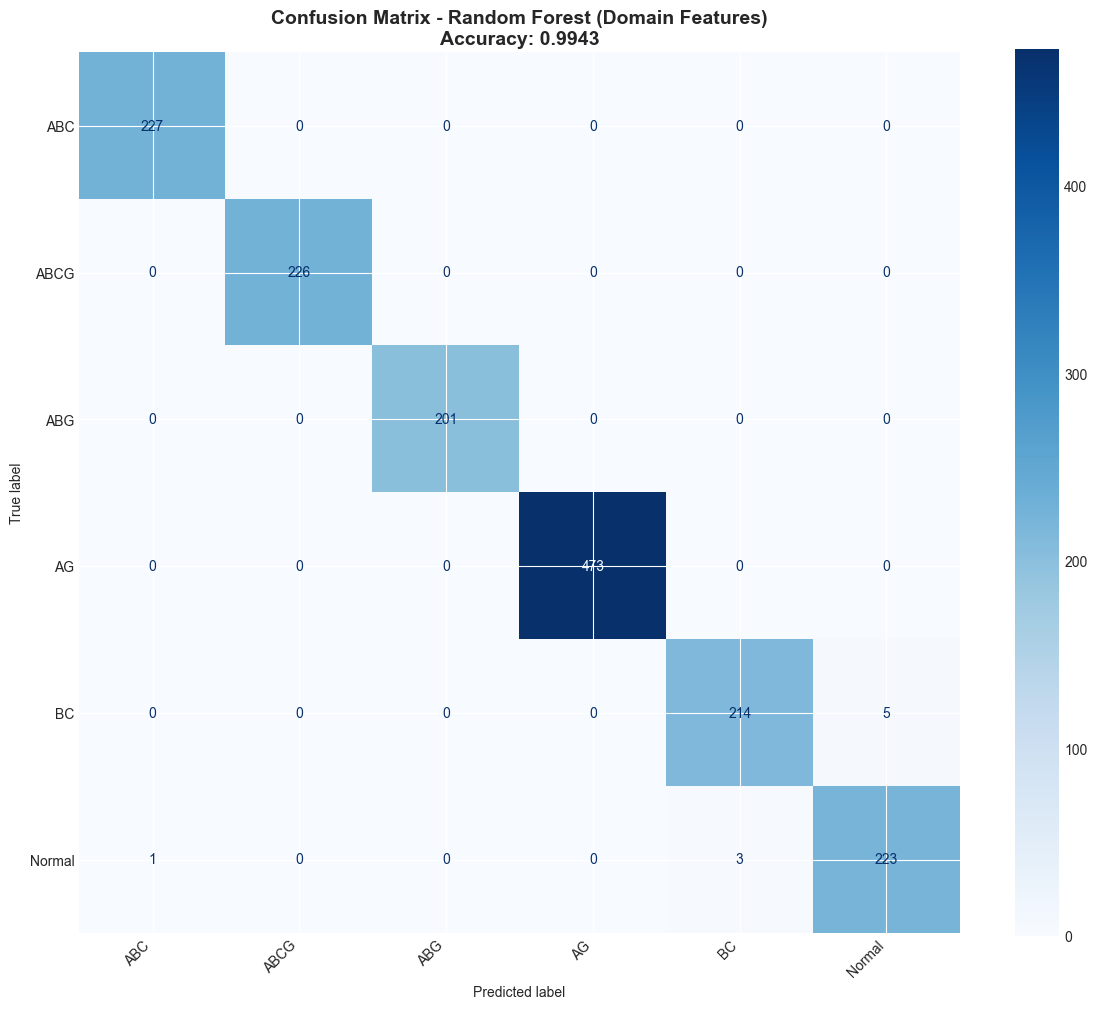


Confusion matrix visualized and saved!
Confusion matrix data saved!


In [31]:
print('\nCONFUSION MATRIX - BEST MODEL')
print('-'*60)

# Create confusion matrix
cm = confusion_matrix(y_test, best_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
plt.title(f'Confusion Matrix - {best_model} ({best_config})\n' + 
          f'Accuracy: {best_accuracy:.4f}', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'best_model_confusion_matrix.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print('\nConfusion matrix visualized and saved!')

# Save confusion matrix data
cm_df = pd.DataFrame(cm, 
                     index=label_encoder.classes_, 
                     columns=label_encoder.classes_)
cm_df.to_csv(os.path.join(metrics_dir, 'best_model_confusion_matrix.csv'))
print('Confusion matrix data saved!')

## 17. Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------

Top 20 Most Important Features:
          Feature  Importance
       V1_pos_seq    0.097066
      I_imbalance    0.086444
        I_diff_bc    0.073294
      I0_zero_seq    0.060474
V_total_magnitude    0.058727
            I_sum    0.054875
       I1_pos_seq    0.050821
        I_diff_ab    0.050740
        I_diff_ca    0.050246
      V_imbalance    0.049735
        V_diff_ca    0.047645
I_total_magnitude    0.037483
               Ic    0.030674
        V_diff_ab    0.028591
        V_diff_bc    0.027994
               Ib    0.021964
          P_total    0.019650
               Ia    0.017636
               Va    0.015558
               Vb    0.015539

Full feature importance saved!


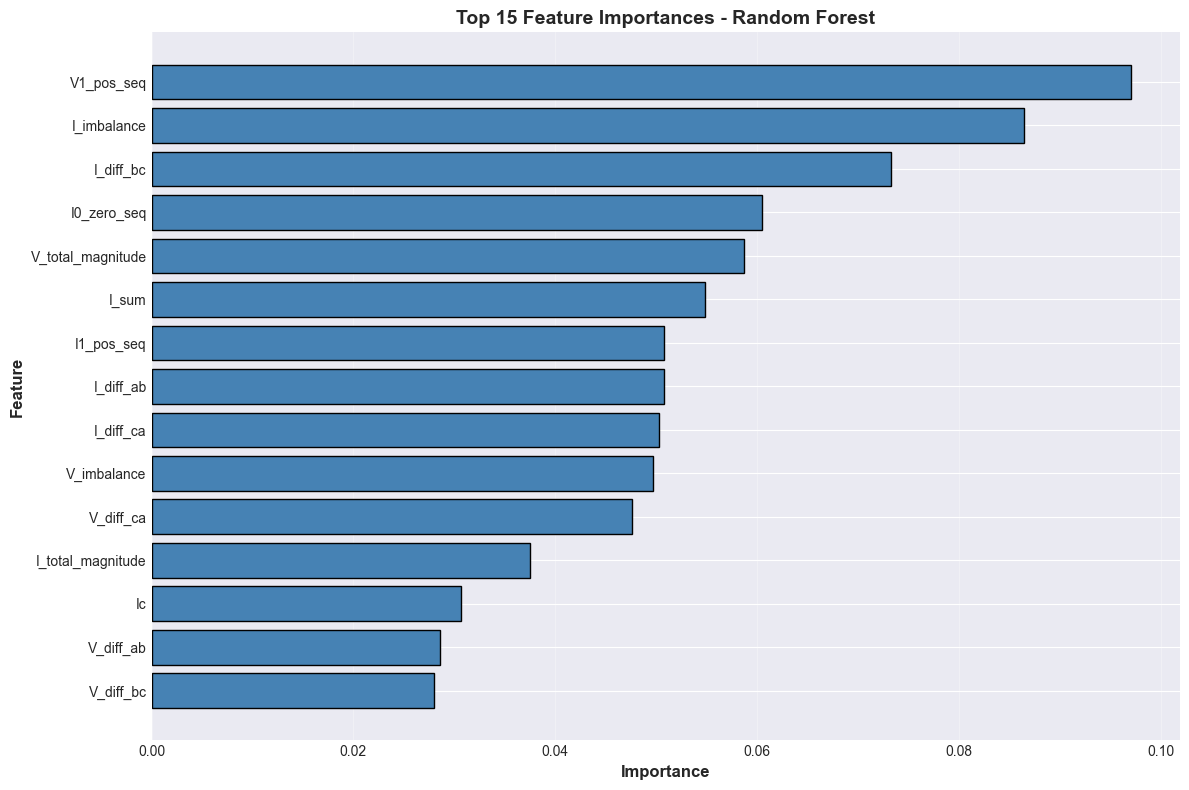


Feature importance visualized and saved!


In [32]:
if best_model in ['Decision Tree', 'Random Forest']:
    print('\nFEATURE IMPORTANCE ANALYSIS')
    print('-'*60)
    
    # Get feature importances
    importances = best_model_obj.feature_importances_
    
    # Get feature names for the best configuration
    if best_config == 'Domain Features':
        feature_names_best = domain_feature_names
    else:
        feature_names_best = poly.get_feature_names_out(original_features)
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names_best,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print('\nTop 20 Most Important Features:')
    print(importance_df.head(20).to_string(index=False))
    
    # Save full importance list
    importance_df.to_csv(os.path.join(metrics_dir, 'feature_importance.csv'), 
                         index=False)
    print(f'\nFull feature importance saved!')
    
    # Visualize top 15 features
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    ax.barh(range(len(top_features)), top_features['Importance'], 
            color='steelblue', edgecolor='black')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 15 Feature Importances - {best_model}', 
                 fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'feature_importance_plot.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nFeature importance visualized and saved!')
else:
    print('\nFeature importance not available for Logistic Regression')
    print('Use coefficient analysis instead (available in scikit-learn)')

## 18. Save Models and Artifacts

In [33]:
print('\nSAVING MODELS AND ARTIFACTS')
print('-'*60)

# Save best model
with open(f'../models/best_model_phase4_{best_model.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)
print(f'\nBest model saved: {best_model} ({best_config})')

# Save enhanced training data
np.save('../data/processed/X_train_domain.npy', X_train_domain)
np.save('../data/processed/X_test_domain.npy', X_test_domain)
print('Domain-enhanced data saved')

# Save polynomial feature transformer
with open('../models/polynomial_features_transformer.pkl', 'wb') as f:
    pickle.dump(poly, f)
print('Polynomial feature transformer saved')

# Save polynomial data
np.save('../data/processed/X_train_poly.npy', X_train_poly)
np.save('../data/processed/X_test_poly.npy', X_test_poly)
print('Polynomial-enhanced data saved')

# Save feature names
with open('../data/processed/domain_feature_names.txt', 'w') as f:
    for name in domain_feature_names:
        f.write(f"{name}\n")
print('Domain feature names saved')

# Save all trained models for comparison
models_to_save = {
    'lr_domain': lr_domain,
    'dt_domain': dt_domain,
    'rf_domain': rf_domain,
    'lr_poly': lr_poly,
    'dt_poly': dt_poly,
    'rf_poly': rf_poly
}

for model_name, model_obj in models_to_save.items():
    with open(f'../models/phase4_{model_name}.pkl', 'wb') as f:
        pickle.dump(model_obj, f)

print('All Phase 4 models saved')


SAVING MODELS AND ARTIFACTS
------------------------------------------------------------

Best model saved: Random Forest (Domain Features)
Domain-enhanced data saved
Polynomial feature transformer saved
Polynomial-enhanced data saved
Domain feature names saved
All Phase 4 models saved


## 19. Generate Summary Report

In [35]:
summary_report = f"""
FEATURE ENGINEERING RESULTS
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'-'*60}

BASELINE PERFORMANCE (Phase 3 - 6 original features):
- Logistic Regression: {baseline_data['Logistic Regression']['test_acc']:.4f} ({baseline_data['Logistic Regression']['test_acc']*100:.2f}%)
- Decision Tree:       {baseline_data['Decision Tree']['test_acc']:.4f} ({baseline_data['Decision Tree']['test_acc']*100:.2f}%)
- Random Forest:       {baseline_data['Random Forest']['test_acc']:.4f} ({baseline_data['Random Forest']['test_acc']*100:.2f}%)

DOMAIN FEATURES PERFORMANCE ({X_train_domain.shape[1]} features):
- Logistic Regression: {domain_results['Logistic Regression']['test_acc']:.4f} ({domain_results['Logistic Regression']['test_acc']*100:.2f}%) [+{(domain_results['Logistic Regression']['test_acc']-baseline_data['Logistic Regression']['test_acc'])*100:.2f}%]
- Decision Tree:       {domain_results['Decision Tree']['test_acc']:.4f} ({domain_results['Decision Tree']['test_acc']*100:.2f}%) [+{(domain_results['Decision Tree']['test_acc']-baseline_data['Decision Tree']['test_acc'])*100:.2f}%]
- Random Forest:       {domain_results['Random Forest']['test_acc']:.4f} ({domain_results['Random Forest']['test_acc']*100:.2f}%) [+{(domain_results['Random Forest']['test_acc']-baseline_data['Random Forest']['test_acc'])*100:.2f}%]

POLYNOMIAL FEATURES PERFORMANCE ({X_train_poly.shape[1]} features):
- Logistic Regression: {poly_results['Logistic Regression']['test_acc']:.4f} ({poly_results['Logistic Regression']['test_acc']*100:.2f}%) [+{(poly_results['Logistic Regression']['test_acc']-baseline_data['Logistic Regression']['test_acc'])*100:.2f}%]
- Decision Tree:       {poly_results['Decision Tree']['test_acc']:.4f} ({poly_results['Decision Tree']['test_acc']*100:.2f}%) [+{(poly_results['Decision Tree']['test_acc']-baseline_data['Decision Tree']['test_acc'])*100:.2f}%]
- Random Forest:       {poly_results['Random Forest']['test_acc']:.4f} ({poly_results['Random Forest']['test_acc']*100:.2f}%) [+{(poly_results['Random Forest']['test_acc']-baseline_data['Random Forest']['test_acc'])*100:.2f}%]

BEST OVERALL MODEL:
- Model: {best_model}
- Feature Set: {best_config}
- Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)
- Improvement over baseline: +{(best_accuracy - baseline_data[best_model]['test_acc'])*100:.2f}%

TARGET ACHIEVEMENT:
- Target Accuracy: 95.00%
- Best Achieved: {best_accuracy*100:.2f}%
- Status: {'TARGET MET!' if best_accuracy >= 0.95 else f'Need +{(0.95 - best_accuracy)*100:.2f}% more'}

ENGINEERED FEATURES CREATED:
- Zero-sequence current (I0) and voltage (V0)
- Positive-sequence approximations (I1, V1)
- Phase impedances (Z_a, Z_b, Z_c)
- Total magnitudes (I_total, V_total)
- Imbalance indicators (I_imbalance, V_imbalance)
- Power approximations (P_a, P_b, P_c, P_total)
- Current and voltage sums (I_sum, V_sum)
- Phase differences (I_diff_ab, I_diff_bc, I_diff_ca, V_diff_ab, V_diff_bc, V_diff_ca)

NEXT STEPS:
{'- Phase 5: Try advanced algorithms (XGBoost, LightGBM, CatBoost)' if best_accuracy < 0.95 else '- Phase 6: Hyperparameter tuning'}
- Analyze feature importance in detail
- Consider feature selection for simplification
- Test ensemble methods

{'-'*60}
"""

print(summary_report)

# Save summary report
with open(os.path.join(output_dir, 'FEATURE_ENGINEERING_SUMMARY.txt'), 'w') as f:
    f.write(summary_report)

print('Summary report saved!')


FEATURE ENGINEERING RESULTS
Generated: 2025-12-27 18:57:45
------------------------------------------------------------

BASELINE PERFORMANCE (Phase 3 - 6 original features):
- Logistic Regression: 0.3458 (34.58%)
- Decision Tree:       0.8856 (88.56%)
- Random Forest:       0.8798 (87.98%)

DOMAIN FEATURES PERFORMANCE (29 features):
- Logistic Regression: 0.7298 (72.98%) [+38.40%]
- Decision Tree:       0.9822 (98.22%) [+9.66%]
- Random Forest:       0.9943 (99.43%) [+11.45%]

POLYNOMIAL FEATURES PERFORMANCE (27 features):
- Logistic Regression: 0.7438 (74.38%) [+39.80%]
- Decision Tree:       0.9027 (90.27%) [+1.71%]
- Random Forest:       0.8900 (89.00%) [+1.02%]

BEST OVERALL MODEL:
- Model: Random Forest
- Feature Set: Domain Features
- Test Accuracy: 0.9943 (99.43%)
- Improvement over baseline: +11.45%

TARGET ACHIEVEMENT:
- Target Accuracy: 95.00%
- Best Achieved: 99.43%
- Status: TARGET MET!

ENGINEERED FEATURES CREATED:
- Zero-sequence current (I0) and voltage (V0)
- Positive

## 20. Summary

**Phase 4: Feature Engineering - Complete**

**Accomplishments:**
- Created domain-based electrical features
- Created polynomial interaction features
- Trained 6 models with different feature sets
- Compared performance improvements
- Identified best model configuration
- Analyzed feature importance

**Files Generated:**
- Models: All trained models saved in models/
- Data: Enhanced datasets saved in data/processed/
- Metrics: Performance comparisons in results/feature_engineering/metrics/
- Plots: Visualizations in results/feature_engineering/plots/

**Next Phase:**
Depending on results, proceed to either advanced algorithms (Phase 5) or hyperparameter tuning (Phase 6)